# AD ASTRA Collision tracking

In [27]:
# Uncomment the below lines and run the cell before executing, comment it out after all installs are done

# !pip install --upgrade pip
# !pip install sgp4
# !pip install numpy
# !pip install spacetrack
# !pip install asyncio
# !pip install skyfield
# !pip install matplotlib



In [28]:
# Time to do all the imports
from spacetrack import SpaceTrackClient
from skyfield.api import Loader, EarthSatellite
from skyfield.timelib import Time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json


In [29]:
# Lets collect some trash!
from spacetrack import SpaceTrackClient
import json

st = SpaceTrackClient('email.jrv@gmail.com', 'cyQgit-mapci5-dotrif') # everyone should not run this at once lol
trash = st.tle_latest( object_type='debris', ordinal=1, format='json', orderby='norad_cat_id' ) # TODO : Stream this stuff, choose fewer elements
trash_dict = json.loads(trash)

2437213.8332023206
(3, 300)
hw was None so set to: 7352.871410417255
centers are:  [-158.38710929151694, 0.0, 0.0]
hw is:        7352.871410417255


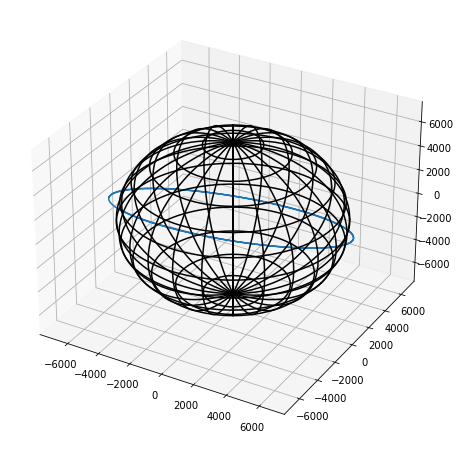

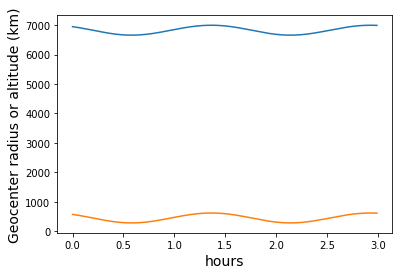

In [30]:
# Lets viz two orbits
L1 = trash_dict[0]['TLE_LINE1']
L2 = trash_dict[0]['TLE_LINE2']

halfpi, pi, twopi = [f*np.pi for f in [0.5, 1, 2]]
degs, rads = 180/pi, pi/180

def makecubelimits(axis, centers=None, hw=None):
    lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
    if centers == None:
        centers = [0.5*sum(pair) for pair in lims] 

    if hw == None:
        widths  = [pair[1] - pair[0] for pair in lims]
        hw      = 0.5*max(widths)
        ax.set_xlim(centers[0]-hw, centers[0]+hw)
        ax.set_ylim(centers[1]-hw, centers[1]+hw)
        ax.set_zlim(centers[2]-hw, centers[2]+hw)
        print("hw was None so set to:", hw)
    else:
        try:
            hwx, hwy, hwz = hw
            print("ok hw requested: ", hwx, hwy, hwz)

            ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
            ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
            ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
        except:
            print("nope hw requested: ", hw)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)

    return centers, hw



load = Loader('~/Documents/fishing/SkyData')
data = load('de421.bsp')
ts   = load.timescale()

planets = load('de421.bsp')
earth   = planets['earth']

Roadster = EarthSatellite(L1, L2)

print(Roadster.epoch.tt)
hours = np.arange(0, 3, 0.01)

time = ts.utc(2018, 2, 7, hours)

Rpos    = Roadster.at(time).position.km
Rposecl = Roadster.at(time).ecliptic_position().km

print(Rpos.shape)

re = 6378.

theta = np.linspace(0, twopi, 201)
cth, sth, zth = [f(theta) for f in [np.cos, np.sin, np.zeros_like]]
lon0 = re*np.vstack((cth, zth, sth))
lons = []
for phi in rads*np.arange(0, 180, 15):
    cph, sph = [f(phi) for f in [np.cos, np.sin]]
    lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                     lon0[1]*cph + lon0[0]*sph,
                     lon0[2]) )
    lons.append(lon)

lat0 = re*np.vstack((cth, sth, zth))
lats = []
for phi in rads*np.arange(-75, 90, 15):
    cph, sph = [f(phi) for f in [np.cos, np.sin]]
    lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
    lats.append(lat)

if True:    
    fig = plt.figure(figsize=[10, 8])  # [12, 10]

    ax  = fig.add_subplot(1, 1, 1, projection='3d')

    x, y, z = Rpos
    ax.plot(x, y, z)
    for x, y, z in lons:
        ax.plot(x, y, z, '-k')
    for x, y, z in lats:
        ax.plot(x, y, z, '-k')

    centers, hw = makecubelimits(ax)

    print("centers are: ", centers)
    print("hw is:       ", hw)

    plt.show()

r_Roadster = np.sqrt((Rpos**2).sum(axis=0))
alt_roadster = r_Roadster - re

if True:
    plt.figure()
    plt.plot(hours, r_Roadster)
    plt.plot(hours, alt_roadster)
    plt.xlabel('hours', fontsize=14)
    plt.ylabel('Geocenter radius or altitude (km)', fontsize=14)
    plt.show()